## Applied bioinformatics final project


### Here we want you to explore whether proteins with a high node-degree in protein interaction networks, also have a larger number of protein domains.

To do so you should write a set of instructions and python scripts that:

1. Downloads the Homo sapiens part of STRING, a database from protein-protein interactions, from
* https://stringdb-static.org/download/protein.links.v11.0/9606.protein.links.v11.0.txt.gz (Links to an external site.)
The link above is from their download page.
2. Create an interaction network by selecting the edges with a "combined score" larger or equal to 500, a number which indicates significance.
3. Partition the proteins in two groups, the ones with a node degree larger than 100 and one smaller or equal to 100.
4. Download the number of known protein-domains per Ensembl id from:
* https://stockholmuniversity.box.com/s/n8l0l1b3tg32wrzg2ensg8dnt7oua8ex
This file was exported from Ensembl's BioMart (Links to an external site.) service and contains two columns: Pfam ID (for protein domains) and Ensembl protein ID (which is also used by the string database). Note: some proteins have no protein domain registered.
5. Make a boxplot, comparing the number of domains of proteins with node degrees >100 to the ones with node degrees <=100.

Create a GitHub repository containing a Makefile so that when we download the project we could run the command
```
git clone your_repo.git
cd your_repo
make
```
to get a file "protein_domains_vs_string_degree.png". Your project succeeds if we succeed reproducing the plot!

In [70]:
# loading modules

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

import networkx as nx

In [13]:
# reading data
network_data_frame = pd.read_csv('../data/9606.protein.links.v11.0.txt.gz', compression='gzip',
                                  sep=' ')
network_data_frame = network_data_frame[network_data_frame['combined_score'] >= 500]

protein_domain = pd.read_csv('../data/proteins_w_domains.txt', sep='\t').rename(columns = {'Pfam ID': 'domain_ID', 'Protein stable ID': 'protein_ID'}, inplace = False)


In [3]:
# generating network data
network = nx.from_pandas_edgelist(network_data_frame, source = 'protein1', target = 'protein2')

In [19]:
def grouping_by_degree(network):
    """funtion to separed a network between larger or smaller than 100 node degrees and return 
    a data_frame with their names
    """
    degree_dict = dict(network.degree(network.nodes()))
    nx.set_node_attributes(network, degree_dict, 'degree')
    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    df_group = pd.DataFrame(columns=['node_degree', 'protein_ID', 'degree_value']) 

    for key, value in degree_dict.items():
        key = key.replace('9606.','')
        if value > 100:
            df_group = df_group.append({'node_degree' : 'larger_100', 'protein_ID' : key, 'degree_value' : value}, ignore_index=True)
        else:
            df_group = df_group.append({'node_degree' : 'smaller_100', 'protein_ID' : key, 'degree_value' : value}, ignore_index=True)
    
    return df_group

grouped_by_degree = grouping_by_degree(network)

In [87]:
# merging dataframes

prot_degree_domain = pd.merge(grouped_by_degree, protein_domain.dropna(), on = 'protein_ID')

prot_domain_count = prot_degree_domain.groupby(['protein_ID','node_degree','degree_value']).count().reset_index()

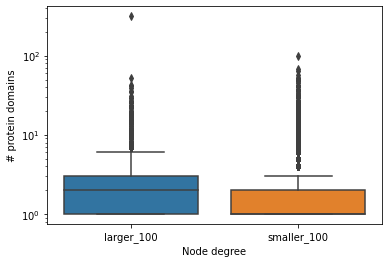

In [91]:
# plotting
def plotting_degre_x_domains(dataframe): 
    plot = sns.boxplot(y = 'domain_ID', x = 'node_degree', data = dataframe)
    plt.xlabel('Node degree')
    plt.ylabel('# protein domains')
    plot.set(yscale="log")
    plt.savefig('../results/protein_intereactions-domains.png')
    
plotting_degre_x_domains(prot_domain_count)

In [103]:
def basic_statistics(dataframe, file_output):
    """
    Basic statistics groupped by larger than 100 node degrees and less or equal than 100 node degree 
    and saved as csv on the results folder
    """
    stats_by_node = dataframe.groupby('node_degree').describe()
    stats_by_node.to_csv(file_output)
    

basic_statistics(prot_domain_count, '../results/basic_statistics.csv')
